In [7]:
pip install pandas numpy nltk scikit-learn seaborn


Note: you may need to restart the kernel to use updated packages.


# Exploring the Dataset 

In [8]:
import pandas as pd
import numpy as np
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
import re
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [9]:
data = pd.read_csv("News Dataset.csv")

In [48]:
print(data.head())  # First 5 rows
print(data.tail())  # Last 5 rows


                                      headline category               date  \
0  የኦሊምፒክ ማጣሪያ ተሳታፊዎች የሚለዩበት ቻምፒዮና እየተካሄደ ይገኛል     ስፖርት   January 14, 2021   
1                                   አዲስ ዘመን ድሮ     መዝናኛ  December 28, 2020   
2             የአረንጓዴ ጎርፍ በጎ አድራጎት አምባሳደሮች ተሰየሙ     ስፖርት    January 6, 2021   
3        የሊጉ በቢዝነስ ሞዴል መመራት አበረታች ጅምር መሆኑ ተገለጸ     ስፖርት    January 6, 2021   
4    የኦሊምፒክ ሥራ አስፈፃሚው እስከ ቶኪዮ ኦሊምፒክ ማግስት ይቀጥላል     ስፖርት    January 6, 2021   

  views                                            article  \
0     2  ብርሀን ፈይሳየኢትዮጵያ ቦክስ ፌዴሬሽን በየአመቱ የሚያዘጋጀው የክለቦች ቻ...   
1     4   የአዲስ ዘመን ጋዜጣ ቀደምት ዘገባዎች በእጅጉ ተነባቢ ዛሬም ላገኛቸው በ...   
2     6  ቦጋለ አበበየአዲስ አበባ ከተማ አስተዳደር ስፖርት ኮሚሽን ከኢትዮጵያ አረ...   
3     5  ብርሀን ፈይሳአዲስ አበባ፡- የኢትዮጵያ ፕሪምየር ሊግ በሼር ካምፓኒ እንዲ...   
4    12  ቦጋለ አበበ የኢትዮጵያ ኦሊምፒክ ኮሚቴ አርባ አምስተኛ መደበኛ ጠቅላላ ጉ...   

                                link  \
0  https://www.press.et/Ama/?p=39481   
1  https://www.press.et/Ama/?p=38334   
2  https://www.press.et/Ama/?p=39010  

In [49]:
print(data.info())  # Data types, non-null values, memory usage


<class 'pandas.core.frame.DataFrame'>
Index: 51470 entries, 0 to 51482
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   headline  51470 non-null  object
 1   category  51470 non-null  object
 2   date      51470 non-null  object
 3   views     51470 non-null  object
 4   article   51470 non-null  object
 5   link      51470 non-null  object
 6   tokens    51470 non-null  object
dtypes: object(7)
memory usage: 3.1+ MB
None


In [12]:
print(data.shape)  # (rows, columns)

(51483, 6)


In [13]:
print(data.isnull().sum())  # Count missing values in each column

headline    13
category     1
date         0
views        0
article      0
link         0
dtype: int64


In [14]:
data=data.dropna() # removing rows with null values because they are not many
print(data.shape)  # (rows, columns)

(51470, 6)


In [15]:
data.category.unique()

array(['ስፖርት', 'መዝናኛ', 'ሀገር አቀፍ ዜና', 'ቢዝነስ', 'ዓለም አቀፍ ዜና', 'ፖለቲካ'],
      dtype=object)

In [16]:
import re

def normalize_char(token):
    subs = [
        ('[ሃኅኃሐሓኻ]', 'ሀ'), ('[ሑኁዅ]', 'ሁ'), ('[ኂሒኺ]', 'ሂ'),
        ('[ኌሔዄ]', 'ሄ'), ('[ሕኅ]', 'ህ'), ('[ኆሖኾ]', 'ሆ'),
        ('[ሠ]', 'ሰ'), ('[ሡ]', 'ሱ'), ('[ሢ]', 'ሲ'),
        ('[ሣ]', 'ሳ'), ('[ሤ]', 'ሴ'), ('[ሥ]', 'ስ'),
        ('[ሦ]', 'ሶ'), ('[ዓኣዐ]', 'አ'), ('[ዑ]', 'ኡ'),
        ('[ዒ]', 'ኢ'), ('[ዔ]', 'ኤ'), ('[ዕ]', 'እ'),
        ('[ዖ]', 'ኦ'), ('[ጸ]', 'ፀ'), ('[ጹ]', 'ፁ'),
        ('[ጺ]', 'ፂ'), ('[ጻ]', 'ፃ'), ('[ጼ]', 'ፄ'),
        ('[ጽ]', 'ፅ'), ('[ጾ]', 'ፆ'), ('(ሉ[ዋአ])', 'ሏ'),
        ('(ሙ[ዋአ])', 'ሟ'), ('(ቱ[ዋአ])', 'ቷ'), ('(ሩ[ዋአ])', 'ሯ'),
        ('(ሱ[ዋአ])', 'ሷ'), ('(ሹ[ዋአ])', 'ሿ'), ('(ቁ[ዋአ])', 'ቋ'),
        ('(ቡ[ዋአ])', 'ቧ'), ('(ቹ[ዋአ])', 'ቿ'), ('(ሁ[ዋአ])', 'ኋ'),
        ('(ኑ[ዋአ])', 'ኗ'), ('(ኙ[ዋአ])', 'ኟ'), ('(ኩ[ዋአ])', 'ኳ'),
        ('(ዙ[ዋአ])', 'ዟ'), ('(ጉ[ዋአ])', 'ጓ'), ('(ደ[ዋአ])', 'ዷ'),
        ('(ጡ[ዋአ])', 'ጧ'), ('(ጩ[ዋአ])', 'ጯ'), ('(ጹ[ዋአ])', 'ጿ'),
        ('(ፉ[ዋአ])', 'ፏ'), ('[ቊ]', 'ቁ'), ('[ኵ]', 'ኩ')
    ]
    
    for pattern, replacement in subs:
        token = re.sub(pattern, replacement, token)

    return token


In [17]:
data['article'] = data['article'].str.replace('[^\w\s]','')
data['article'] = data['article'].apply(lambda x: normalize_char(x))

### Tokenization Split the Amharic text into individual words (tokens) using a tokenizer.

In [18]:

nltk.download('punkt_tab')
data['tokens'] = data['article'].apply(lambda x: word_tokenize(x))
print(data['tokens'].head())

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\micha\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


0    [ብርሀን, ፈይሳየኢትዮጵያ, ቦክስ, ፌዴሬሽን, በየአመቱ, የሚያዘጋጀው, ...
1    [የአዲስ, ዘመን, ጋዜጣ, ቀደምት, ዘገባዎች, በእጅጉ, ተነባቢ, ዛሬም,...
2    [ቦጋለ, አበበየአዲስ, አበባ, ከተማ, አስተዳደር, ስፖርት, ኮሚሽን, ከ...
3    [ብርሀን, ፈይሳአዲስ, አበባ፡-, የኢትዮጵያ, ፕሪምየር, ሊግ, በሼር, ...
4    [ቦጋለ, አበበ, የኢትዮጵያ, ኦሊምፒክ, ኮሚቴ, አርባ, አምስተኛ, መደበ...
Name: tokens, dtype: object


### Stopword Removal Remove common words (stopwords) that don’t add meaning

In [19]:
amharic_stopwords = ['እንዲሁም', 'እና', 'የሆነ', 'ወይም', 'ለምሳሌ']  # Add more stopwords
data['tokens'] = data['tokens'].apply(lambda x: [word for word in x if word not in amharic_stopwords])


Vectorization (Converting Text to Numbers)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(data['article'])  # Convert text to vectors
y = data['category']  # Labels for classification


In [21]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))


Accuracy: 0.8324266563046435


c:\Users\micha\anaconda3\envs\news_classifier\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [23]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

  ሀገር አቀፍ ዜና       0.79      0.88      0.84      4095
        መዝናኛ       0.87      0.61      0.72       134
        ስፖርት       0.98      0.97      0.97      2096
        ቢዝነስ       0.68      0.56      0.62       767
  ዓለም አቀፍ ዜና       0.88      0.83      0.85      1345
        ፖለቲካ       0.77      0.70      0.74      1857

    accuracy                           0.83     10294
   macro avg       0.83      0.76      0.79     10294
weighted avg       0.83      0.83      0.83     10294

[[3615    4   26  105   88  257]
 [  43   82    2    2    5    0]
 [  67    1 2025    0    1    2]
 [ 241    3    0  430    6   87]
 [ 174    2    8   10 1114   37]
 [ 414    2    2   82   54 1303]]


c:\Users\micha\anaconda3\envs\news_classifier\lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 4608 (\N{ETHIOPIC SYLLABLE HA}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
c:\Users\micha\anaconda3\envs\news_classifier\lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 4872 (\N{ETHIOPIC SYLLABLE GA}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
c:\Users\micha\anaconda3\envs\news_classifier\lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 4653 (\N{ETHIOPIC SYLLABLE RE}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
c:\Users\micha\anaconda3\envs\news_classifier\lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 4768 (\N{ETHIOPIC SYLLABLE GLOTTAL A}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
c:\Users\micha\anaconda3\envs\news_classifier\lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 4672 (\N{ETHIOPIC SYLLABLE QA}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
c:\Users\micha\anaconda3\envs\news_classifi

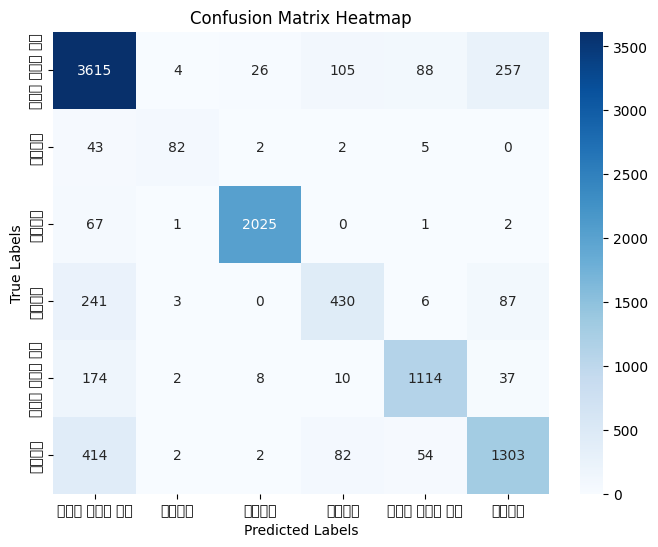

In [24]:

# Compute and visualize the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')
plt.show()


findfont: Font family 'Noto Sans Ethiopic' not found.
findfont: Font family 'Noto Sans Ethiopic' not found.
c:\Users\micha\anaconda3\envs\news_classifier\lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 4608 (\N{ETHIOPIC SYLLABLE HA}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
c:\Users\micha\anaconda3\envs\news_classifier\lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 4872 (\N{ETHIOPIC SYLLABLE GA}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
c:\Users\micha\anaconda3\envs\news_classifier\lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 4653 (\N{ETHIOPIC SYLLABLE RE}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
c:\Users\micha\anaconda3\envs\news_classifier\lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 4768 (\N{ETHIOPIC SYLLABLE GLOTTAL A}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
c:\Users\micha\anaconda3\envs\news_classifier\lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 4672 (\N{ETHIOPIC SYL

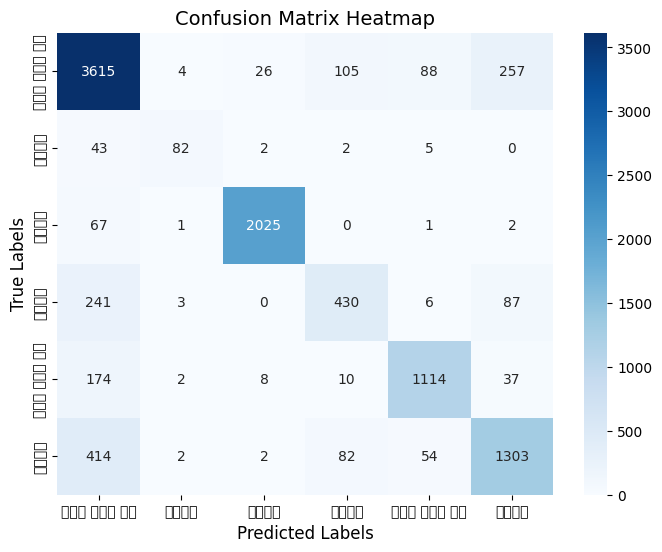

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)

# Unique labels in the dataset
labels = np.unique(y_test)

# Create a DataFrame for the confusion matrix
df_cm = pd.DataFrame(conf_matrix, index=labels, columns=labels)

# Set the font to Noto Sans Ethiopic
plt.rcParams['font.family'] = 'Noto Sans Ethiopic'

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues')

plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)
plt.title('Confusion Matrix Heatmap', fontsize=14)
plt.show()

In [ ]:
# New unseen Amharic article
# new_article =" “ ወደ አራት ጤና ባለሙያዎች ገና አልተፈቱም። የጠየቁት መብታቸውን ስለሆነ ሊፈቱ ይገባል ”"
# new_article ="የለንደኑ ክለብ ቼልሲ የ ሲቪያዉን ተጫዋች ጁልስ ኮንዴን የማስፈረም ፍላጎት የነበራቸዉን አንስተዋል።"
# new_article ="ከምያንማር የወንጀል ካምፖች የወጡ ከ800 በላይ ኢትዮጵያውያን በተለያዩ ታጣቂዎች እጅ ይገኛሉ"
# new_article ="ሊቨርፑል ከአርሰናል በ13 ነጥብ ርቆ ወደ ዋንጫ የሚያደርገውን ግስጋሴ ቀጥሎበታል"
# new_article ="የአሜሪካ ዜግነት ያስገኛል የተባለው የወርቅ ካርድ ምንድነው? ለእነማንስ ይሸጣል?"
# new_article ="ነዳጅ ከመሸጫ ዋጋ በላይ የሚሸጡ ነጋዴዎችን እስከ 500 ሺህ ብር የሚያስቀጣ አዋጅ ጸደቀ"



# Preprocess the text (same as before)
new_article = re.sub(r'[^\w\s]', '', new_article)  # Remove punctuation
new_article = normalize_char(new_article)  # Normalize characters
tokens = word_tokenize(new_article)  # Tokenization
tokens = [word for word in tokens if word not in amharic_stopwords]  # Stopword removal

# Convert to vector using the existing vectorizer
X_single = vectorizer.transform([" ".join(tokens)])

# Predict the category
predicted_category = model.predict(X_single)[0]

print("Predicted Category:", predicted_category)


Predicted Category: ስፖርት
